In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

import pymysql
pymysql.install_as_MySQLdb()

from flask import Flask, jsonify

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
#Make a connection
conn = engine.connect()

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
#Create an inspector
inspector = inspect(conn)

In [12]:
#List tables
mcolumns = [m.key for m in Measurement.__table__.columns]
print(mcolumns)
scolumns = [s.key for s in Station.__table__.columns]
print(scolumns)

['id', 'station', 'date', 'prcp', 'tobs']
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


# Exploratory Climate Analysis

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#get current time in terms of EST because we're in EST

#from pytz import timezone
#tz = timezone('EST')
#currentTime = dt.datetime.now(tz)

#get time from 12 months ago (52 weeks)

#oneYrAgo = currentTime - dt.timedelta(weeks=52)
#print(oneYrAgo)

#last12Months = session.query(Measurement).filter(Measurement.date > oneYrAgo).all()
#print(last12Months)
#Above method doesn't work since the latest entry in table is from 2017, so let's do
#last 12 months from the last date in the column

latestDate = dt.datetime.strptime(session.query(Measurement.date).\
                                  order_by('date desc').first()[0],'%Y-%m-%d')
oneYrBefore = latestDate - dt.timedelta(weeks=52)
last12Months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=oneYrBefore).all()
#print(last12Months)
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

#whoops I just saw these I'm sorry ^^

# Save the query results as a Pandas DataFrame and set the index to the date column
precipdf = pd.DataFrame(last12Months, columns = ['Date','Precipitation'])
#precipdf = precipdf.dropna().set_index('Date')
precipdf.head()

,Date,Precipitation
0,2016-08-25,0.08
1,2016-08-26,0.00
2,2016-08-27,0.00
3,2016-08-28,0.01
4,2016-08-29,0.00


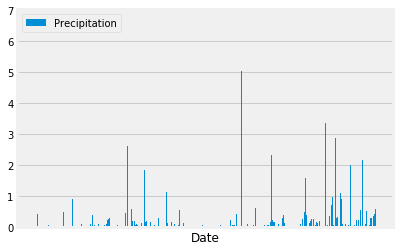

In [18]:
# Sort the dataframe by date
precipdf = precipdf.sort_values(by='Date', ascending = False)
precipdf

# Use Pandas Plotting with Matplotlib to plot the data
fig,ax = plt.subplots()
ax.bar(precipdf.index,precipdf['Precipitation'],label='Precipitation')
ax.grid(which={'both'},axis={'both'},linestyle='-',linewidth=2)
ax.set_xticks([])
ax.set_xlabel('Date')
ax.legend()
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipdf.describe()

,Precipitation
count,2009.000000
mean,0.172344
std,0.452818
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
countStations = session.query(Measurement.station).group_by(Measurement.station).count()
countStations

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.id)).order_by(func.count(Measurement.id).desc()).group_by(Measurement.station).all()
print(f"Station {stations[0][0]} has the highest number of observations")
stations

Station USC00519281 has the highest number of observations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mostActiveStats = session.query(func.min(Measurement.tobs),\
                               func.max(Measurement.tobs),
                               func.avg(Measurement.tobs)).filter(Measurement.station==stations[0][0]).all()
mostActiveStats

[(54.0, 85.0, 71.66378066378067)]

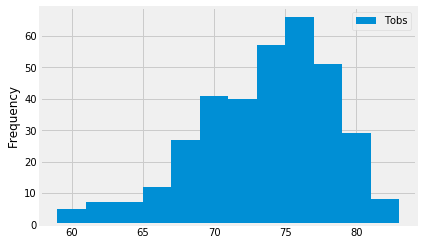

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highTemp = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
highTemp[0]
temp12Months = session.query(Measurement.tobs, Measurement.station).filter(Measurement.date >= oneYrBefore).filter(Measurement.station==highTemp[0]).all()
temp12Months

tempdf = pd.DataFrame(temp12Months, columns = ['Tobs','Station'])
tempdf.plot(kind='hist',bins=12)


In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Trip is from 2017-06-03 to 2017-06-09

temperatures = calc_temps('2017-06-03','2017-06-09')
print(temperatures[0])
print(f"Min temp: {temperatures[0][0]}\nMax temp: {temperatures[0][2]}")
print(f"Average temp: {temperatures[0][1]}")

(72.0, 77.69565217391305, 81.0)
Min temp: 72.0
Max temp: 81.0
Average temp: 77.69565217391305


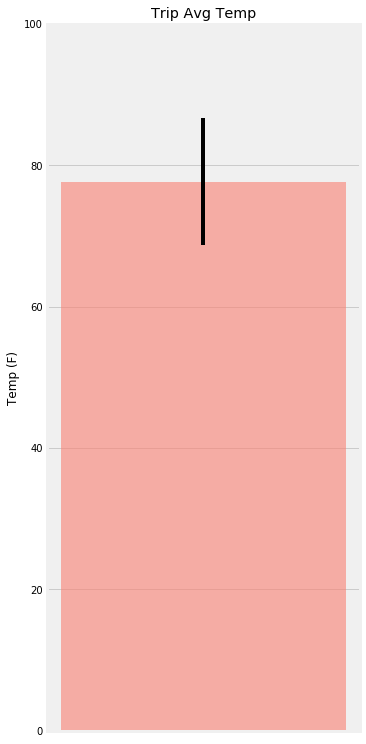

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig1, ax1 = plt.subplots(figsize=[5,13])
ax1.set_xticklabels([])
ax1.set_ylabel('Temp (F)')
ax1.bar(0, temperatures[0][1], color='salmon', align = 'edge',
        yerr=(temperatures[0][2]-temperatures[0][0]),
        width = 0.00001, linewidth=0, alpha=0.6)
ax1.xaxis.grid()
ax1.set_yticks([0,20,40,60,80,100])
plt.title('Trip Avg Temp')
plt.show()

In [24]:
print(mcolumns,scolumns)

['id', 'station', 'date', 'prcp', 'tobs'] ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [31]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#'2017-06-03','2017-06-09'

rainfall = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation).\
filter(Measurement.date >= '2017-06-03').filter(Measurement.date <= '2017-06-09').\
filter(Measurement.station==Station.station).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall
raindf = pd.DataFrame(rainfall, columns=['Station ID','Station Name', 'Precipitation', 'Latitude', 'Longitude', 'Elevation'])
prcp = raindf.to_dict('index')

,Station ID,Station Name,Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.84,21.33310,-157.80250,152.4
1,USC00513117,"KANEOHE 838.1, HI US",0.39,21.42340,-157.80150,14.6
2,USC00519281,"WAIHEE 837.5, HI US",0.28,21.45167,-157.84889,32.9
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.24,21.52130,-157.83740,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.15,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.02,21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",NaN,21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
#'2017-06-03','2017-06-09'
start = dt.datetime.strptime("2017-06-03","%Y-%m-%d")
end = dt.datetime.strptime("2017-06-09","%Y-%m-%d")
# Use the start and end date to create a range of dates
generateDates = [start + dt.timedelta(days=x) for x in range(0,(end-start).days+1)]  
# Stip off the year and save a list of %m-%d strings
strippedDates = []
for date in generateDates:
    strippedDates.append(date.strftime("%m-%d"))
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for day in strippedDates:
    normals.append(daily_normals(day)[0])
normals

[(65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0)]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripTempDf = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
tripTempDf['Date'] = generateDates
tripTempDf = tripTempDf.set_index('Date')
tripTempDf

,tmin,tavg,tmax
Date,,,
2017-06-03,65.0,74.034483,80.0
2017-06-04,65.0,73.818182,81.0
2017-06-05,68.0,74.854545,81.0
2017-06-06,70.0,75.175439,80.0
2017-06-07,68.0,75.071429,81.0
2017-06-08,70.0,75.586207,81.0
2017-06-09,69.0,75.152542,81.0


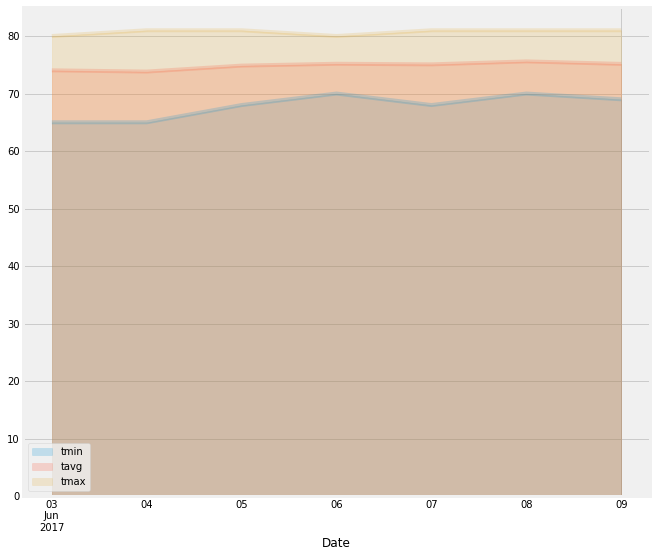

In [39]:
finax = tripTempDf.plot(kind='area',stacked=False,alpha=0.2,grid=True, figsize=[10,9])